# Survey-to-survey Imputation Analysis


In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, make_scorer
import matplotlib.pyplot as plt

In [2]:
MAIN_DIR = "C:\\Users\\md82\\OneDrive - Anglia Ruskin University\\Documents\\mj-datalab\\poverty-prediction-challenge"
DATA_DIR = MAIN_DIR + "\\data\\raw"
SUB_DIR = MAIN_DIR + "\\data\\submission"
TRAIN_DATA = DATA_DIR + "\\train_hh_features.csv"
TEST_DATA = DATA_DIR + "\\test_hh_features.csv"
HH_DATA = DATA_DIR + "\\train_hh_gt.csv"
PR_DATA = DATA_DIR + "\\train_rates_gt.csv"

train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)
hh_data = pd.read_csv(HH_DATA)  
pr_data = pd.read_csv(PR_DATA)

In [3]:
# Check dimensions of training features
print("Shape:", train_data.shape)  # (rows, columns)
print("Rows:", len(train_data))
print("Columns:", len(train_data.columns))
train_data.head()

Shape: (104234, 88)
Rows: 104234
Columns: 88


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


In [4]:
# Check dimensions of training targets
print("Shape:", hh_data.shape)  # (rows, columns)
print("Rows:", len(hh_data))
print("Columns:", len(hh_data.columns))
hh_data.head()

Shape: (104234, 3)
Rows: 104234
Columns: 3


,survey_id,hhid,cons_ppp17
0,100000,100001,25.258402
1,100000,100002,16.996706
2,100000,100003,13.671848
3,100000,100004,7.189475
4,100000,100005,12.308855


In [5]:
# Check dimensions of poverty data
print("Shape:", pr_data.shape)  # (rows, columns)
print("Rows:", len(pr_data))
print("Columns:", len(pr_data.columns))
pr_data.head()

Shape: (3, 20)
Rows: 3
Columns: 20


,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
1,200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
2,300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


## Proverty Rate Calculation

In [6]:
hhs_data = hh_data[['survey_id','cons_ppp17']]
w_data = train_data[['survey_id','weight']]

In [7]:
def get_poverty_thresholds(values, weights, surveys, pr_data):

    # Define thresholds
    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]
    thresholds = np.array(thresholds, dtype=float)
    pr = []

    for s in range(surveys.shape[0]):
        survey_values = values[values['survey_id'] == surveys[s]][['cons_ppp17']].to_numpy().flatten()
        survey_weights = weights[weights['survey_id'] == surveys[s]][['weight']].to_numpy().flatten()

        # Calculate percentage below each 
        percentages = [(survey_weights[survey_values < t].sum() / survey_weights.sum()) for t in thresholds]
        pr.append(percentages)

    df = pd.DataFrame([pr[0]], columns=pr_data.columns.tolist()[1:])
    for d in range(1,len(pr)):
        df = pd.concat([df, pd.DataFrame([pr[d]], columns=pr_data.columns.tolist()[1:])], ignore_index=True)
    
    df.index = surveys
    df.index.name = "survey_id"

    return df

df = get_poverty_thresholds(hh_data, w_data, surveys=hh_data["survey_id"].unique(), pr_data=pr_data)

In [8]:
df.head()

,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
survey_id,,,,,,,,,,,,,,,,,,,
100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


## Check NaNs

In [9]:
# Calculate percentage of missing values in each column
nan_percent = train_data.isna().mean() * 100

In [10]:
# Remove variables with more than 10% missing values
missing_percent = nan_percent[nan_percent > 10]
print("Variables with more than 10% missing values:")
print(missing_percent)

# Remove these variables from the dataset
train_data = train_data.drop(columns=missing_percent.index.tolist())

Variables with more than 10% missing values:
sector1d    13.555078
dtype: float64


## Remove Variables Not Used As Features

In [11]:
# Remove columns from train_data
weights = train_data['weight']
survey = train_data['survey_id']
columns_to_remove = ['hhid', 'com', 'strata', 'weight']
train_data = train_data.drop(columns=columns_to_remove)

In [12]:
train_data.head()

,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,owner,water,toilet,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,594.80627,Female,1,0,0,0,75,Owner,Access,Access,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,1676.27230,Female,2,0,0,0,61,Owner,Access,Access,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,506.93719,Male,5,0,0,2,49,Owner,Access,Access,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,824.61786,Male,5,0,0,1,58,Not owner,Access,Access,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,351.47644,Male,7,1,0,0,57,Owner,Access,Access,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


## Target Variable

In [13]:
X_train = train_data.copy()
y_train = hh_data["cons_ppp17"]

## Create Pipeline

### Infer Feature Types

In [14]:

def infer_feature_types(df, year_col="year"):
    feature_cols = [c for c in df.columns]
    # Simple heuristic: non-numeric or low-cardinality numeric treated as categorical (including year)
    numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
    categorical_cols = [c for c in feature_cols if c not in numeric_cols]

    # Ensure year is treated as categorical (common for pooled models)
    if year_col in numeric_cols:
        numeric_cols.remove(year_col)
    if year_col not in categorical_cols:
        categorical_cols.append(year_col)
    return numeric_cols, categorical_cols

numeric_features, categorical_features = infer_feature_types(train_data, year_col="survey_id")
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['utl_exp_ppp17', 'hsize', 'num_children5', 'num_children10', 'num_children18', 'age', 'num_adult_female', 'num_adult_male', 'num_elderly', 'sworkershh', 'share_secondary', 'sfworkershh', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7']
Categorical features: ['male', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source', 'sanitation_source', 'dweltyp', 'employed', 'educ_max', 'any_nonagric', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400', 'consume

### Pipeline

In [15]:
# Preprocess: impute NaNs, then encode/scale as needed
preprocess = ColumnTransformer(
    transformers=[
        # Median imputation for numeric, then scale
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", "passthrough"),
        ]), numeric_features),

        # Most-frequent imputation for categorical, then one-hot encode
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ]
)

### Model

In [28]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)
#model = HistGradientBoostingRegressor(random_state=0)

pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])

full_pipe = TransformedTargetRegressor(
    regressor=pipe,
    func=np.arcsinh,     # transform target
    inverse_func=np.sinh # back-transform predictions
)

### Hyperparameter Grid

In [29]:
# Winning solution!
param_grid = {
    "regressor__model__n_estimators": [200],
    "regressor__model__max_depth": [10],
    "regressor__model__min_samples_split": [2],
    "regressor__model__min_samples_leaf": [1]
}

#param_grid = {
#    "model__n_estimators": [200, 500],
#    "model__max_depth": [None, 15],
#    "model__min_samples_split": [2, 5],
#    "model__min_samples_leaf": [1, 2],
#    "model__max_features": ["sqrt", 0.5],
#    "model__bootstrap": [True]
#}

# Boosting grid
#param_grid = {
#    "model__n_estimators": [200],
    #"model__learning_rate": [0.005, 0.01, 0.1],
    #"model__max_depth": [2, 4],
    #"model__min_samples_split": [2, 5, 10],
    #"model__min_samples_leaf": [1, 2, 4, 8],
    #"model__subsample": [0.5, 0.7, 0.9, 1.0],
    #"model__max_features": ["sqrt", "log2", None, 0.5],
    #"model__loss": ["squared_error", "absolute_error", "huber"],
#}


In [30]:

groups = train_data["survey_id"]
gkf = GroupKFold(n_splits=3)

search = GridSearchCV(
    estimator=full_pipe,
    param_grid=param_grid,
    cv=gkf.split(X_train, y_train, groups=groups),
    n_jobs=-1,
    verbose=2
)
search.fit(X_train, y_train, **{"model__sample_weight": weights})
    
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200}
Best score: 0.5657998547277264


### Results

In [31]:
best_model = search.best_estimator_

# In-sample predictions (or use CV predictions if desired)
y_pred = best_model.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, )
mae  = mean_absolute_error(y_train, y_pred)
r2   = r2_score(y_train, y_pred)

print("\nPerformance of Best Model:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")


Performance of Best Model:
RMSE: 39.112
MAE:  3.356
R²:   0.612


### Plot Predictions

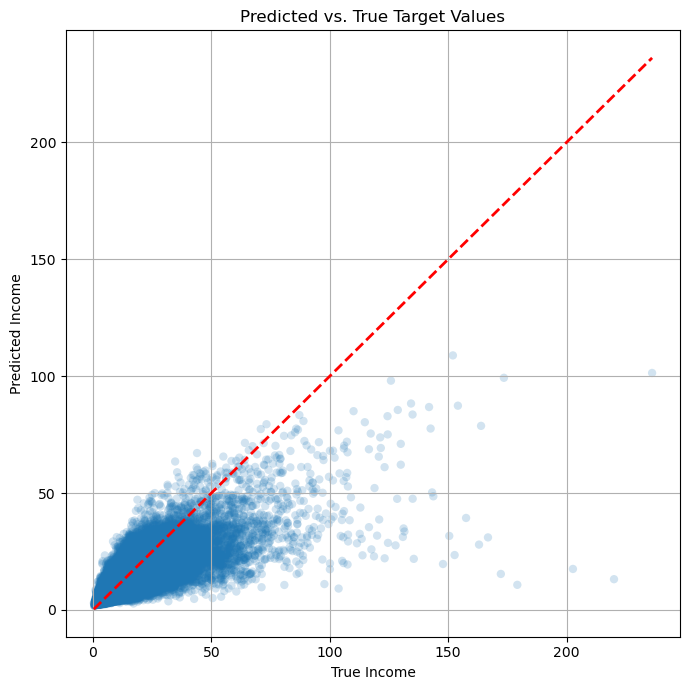

In [32]:
plt.figure(figsize=(7, 7))
plt.scatter(y_train, y_pred, alpha=0.2, edgecolor="none")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", linewidth=2)
plt.xlabel("True Income")
plt.ylabel("Predicted Income")
plt.title("Predicted vs. True Target Values")
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Model

In [ ]:
final_model = search.best_estimator_  # pipeline with tuned hyperparameters
final_model.fit(X_train, y_train, **{"model__sample_weight": weights})

test_sub = test_data[["survey_id","hhid"]]
w_test = test_data[['survey_id','weight']]

X_test = test_data.drop(columns=missing_percent.index.tolist())
X_test = X_test.drop(columns=columns_to_remove)

predictions = final_model.predict(X_test)
y_test = pd.DataFrame(predictions, columns=["cons_ppp17"])

## Feature Importance

In [ ]:
best_model = search.best_estimator_

preprocess = best_model.named_steps["prep"]
rf = best_model.named_steps["model"]

feature_names = preprocess.get_feature_names_out()
importances = rf.feature_importances_

TOP_N = 20

feat_imp_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    .sort_values(by="Importance", ascending=False)
)

top_features = feat_imp_df.head(TOP_N)

plt.figure(figsize=(10, 8))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
plt.title(f"Top {TOP_N} Most Important Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Create Submission

In [ ]:
submission = pd.merge(test_sub, y_test, left_index=True, right_index=True)

values = submission[['survey_id','cons_ppp17']]

submission = submission.set_index("survey_id")
submission.to_csv(SUB_DIR + '\\predicted_household_consumption.csv')

submission_pr = get_poverty_thresholds(values, w_test, surveys = test_data["survey_id"].unique(),pr_data=pr_data)
submission_pr.to_csv(SUB_DIR + '\\predicted_poverty_distribution.csv')


In [ ]:
submission.head()

In [ ]:
submission_pr.head()